In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPUs were originally designed for the significant amount of matrix mathematics used when rendering computer graphics. Neural networks also require a significant amount of matrix multiplication, making GPUs a good fit when building them.

## Data

Speaking of graphics, we're going to tackle a challenge that seemed almost impossible decades ago: image classification with computer vision. Specifically, we will try to classify articles of clothing from the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. A few samples are shown below:

<center><img src="https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true" width="400" /></center>

Neural networks attempt to copy the human learning technique, Trial and Error. To do this, we will create something like a set of digital flashcards. Our artificial brains will attempt to guess what kind of clothing we are showing it with a flashcard, then we will give it the answer, helping the computer learn from its successes and mistakes.

Just like how students are quizzed to test their understanding, we will set aside a portion of our data to quiz our neural networks to make sure they understand the concepts we're trying to teach them, as opposed to them memorizing the answers to their study questions. For trivia, memorization might be an acceptable strategy, but for skills, like adding two numbers, memorization won't get our models very far.

The study data is often called the `training dataset` and the quiz data is often called the `validation dataset`. As Fashion MNIST is a popular dataset, it is already included with the TensorFlow library. Let's load it into our coding environment and take a look at it.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (valid_images, valid_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


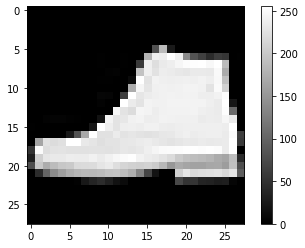

In [3]:
import matplotlib.pyplot as plt

# The question number to study with. Feel free to change up to 59999.
data_idx = 42

plt.figure()
plt.imshow(train_images[data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [4]:
train_labels[data_idx]

9

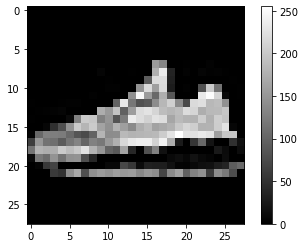

In [5]:
import matplotlib.pyplot as plt

# The question number to quiz with. Feel free to change up to 9999.
data_idx = 6174

plt.figure()
plt.imshow(valid_images[data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
valid_labels[data_idx]

7

In [7]:
# 28 lists with 28 values each
valid_images[data_idx]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

One more thing to think about: the output of `y = mx + b` is a number, but here, we're trying to classify different articles of clothing. How might we convert numbers into categories?

Here is a simple approach: we can make ten neurons, one for each article of clothing. If the neuron assigned to "Trousers" (label #1), has the highest output compared to the other neurons, the model will guess "Trousers" for the given input image.

[Keras](https://keras.io/), a deep learning framework that has been integrated into TensorFlow, makes such a model easy to build. We will use the [Sequential API](https://keras.io/guides/sequential_model/), which allows us to stack [layers](https://keras.io/api/layers/), the list of operations we will be applying to our data as it is fed through the network.

In the below model, we have two layers:
* [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - Converts multidimensional data into 1 dimensional data (ex: a list of lists into a single list).
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) -  A "row" of neurons. Each neuron has a weight (`w`) for each input. In the example below, we use the number `10` to place ten neurons.

We will also define an `input_shape` which is the dimensions of our data. In this case, our `28x28` pixels for each image.

In [8]:
number_of_classes = train_labels.max() + 1
number_of_classes

10

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(number_of_classes)
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [11]:
image_height = 28
image_width = 28

number_of_weights = image_height * image_width * number_of_classes
number_of_weights

7840

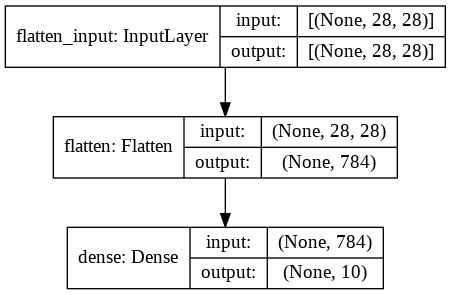

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Initiate Training

We have a model setup, but how does it learn? Just like how students are scored when they take a test, we need to give the model a function to grade its performance. Such a function is called the `loss` function.

In this case, we're going to use a type of function specific to classification called [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy):
* **Sparse** - for this function, it refers to how our label is an interger index for our categories
* **Categorical** - this function was made for classification
* **Cross-entropy** - the more confident our model is when it makes an incorrect guess, the worse its score will be. If a model is 100% confident when it is wrong, it will have a score of negative infinity!
* `from_logits` - the linear output will be transformed into a probability which can be interpreted as the model's confidence a particular category is the correct one for the given input.

This type of loss function works well for our case as it will grade each of the neurons simultaneously. If all of our neurons give a strong signal that they're the correct label, we need a way to tell them that they can't all be right.

For us humans, we can add additional `metrics` to monitor how well our model is learning. For instance, maybe the loss is low, but what if the `accuracy` is not high?

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=True,
    validation_data=(valid_images, valid_labels)
)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 16.5562 - accuracy: 0.7489 - val_loss: 15.7668 - val_accuracy: 0.7662
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 11.8330 - accuracy: 0.7897 - val_loss: 9.8603 - val_accuracy: 0.8082
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 10.9905 - accuracy: 0.7948 - val_loss: 10.1790 - val_accuracy: 0.7964
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 10.4205 - accuracy: 0.8004 - val_loss: 13.1090 - val_accuracy: 0.7663
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 10.4451 - accuracy: 0.8010 - val_loss: 17.5917 - val_accuracy: 0.7619


In [15]:
model.predict(train_images[0:10])

array([[-2.72309418e+02, -6.29265991e+02, -1.48240448e+02,
        -3.04287292e+02, -2.62358246e+02,  4.04356567e+02,
        -6.66822357e+01,  3.52454407e+02,  1.43755692e+02,
         6.60143555e+02],
       [ 6.13844788e+02, -2.70845612e+02,  1.49858749e+02,
         1.61934814e+02, -2.92762756e+01, -1.22549512e+03,
         2.62946960e+02, -1.70582068e+03, -1.39835876e+02,
        -9.54272034e+02],
       [ 2.28563583e+02,  6.38620644e+01,  1.15611488e+02,
         1.60987122e+02,  1.34420044e+02, -4.64505005e+02,
         1.23717628e+02, -4.37717468e+02, -3.56350441e+01,
        -2.16500656e+02],
       [ 3.14445312e+02,  4.27467499e+01,  1.19632019e+02,
         2.59847076e+02,  1.00278206e+02, -8.00684875e+02,
         1.88212570e+02, -9.38515747e+02, -1.47094162e+02,
        -7.07383301e+02],
       [ 4.44294128e+02,  1.99979233e+02,  1.48794876e+02,
         2.97320648e+02,  2.73940704e+02, -9.43392700e+02,
         1.90307541e+02, -6.85627686e+02,  4.39774475e+01,
        -7.

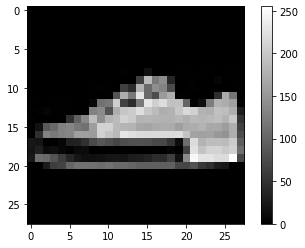

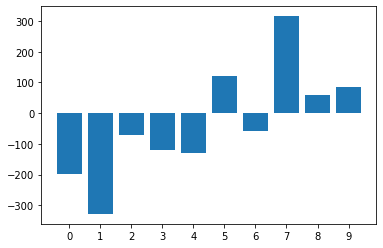

correct answer: 7


In [18]:
data_idx = 8009 # The question number to study with. Feel free to change up to 59999.

plt.figure()
plt.imshow(train_images[data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

x_values = range(number_of_classes)
plt.figure()
plt.bar(x_values, model.predict(train_images[data_idx:data_idx+1]).flatten())
plt.xticks(range(10))
plt.show()

print("correct answer:", train_labels[data_idx])